# Gene and reaction knockouts
This script aims to conduct knockout studies on all models and visualize / report those for the thesis.

*Author: Famke Baeuerle*

In [235]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import refinegems as rg
import pandas as pd
import matplotlib.pyplot as plt
from PARAMS import *
from matplotlib import transforms as tf

REAC_URL = 'http://bigg.ucsd.edu/api/v2/universal/reactions/'
METAB_URL = 'http://bigg.ucsd.edu/api/v2/universal/metabolites/'

### Workflow to access essential genes per model

We load the model we are working with via cobra as `model` and via libSBML as `MODEL` to be used with the functions below.

In [ ]:
modelname = 'Cstr_1197'
modelpath = '../../models/' + modelname + '.xml'
MODEL = rg.io.load_model_libsbml(modelpath)
model = rg.io.load_model_cobra(modelpath)

We define some functions that can be used with the pandas `apply` function.

In [204]:
def set_to_id(id):
    return list(id)[0]

def get_gene_name(gene):
    """Extract gene name to add to table with essential genes"""
    gene = 'G_' + gene
    return MODEL.getPlugin(0).getGeneProduct(gene).getName()

def get_associated_reactions(gene):
    """Extract associated reactions with a specific gene"""
    gene = 'G_' + gene
    reacs = MODEL.getListOfReactions()
    gpr_list = []
    for reac in reacs:
        gpa = reac.getPlugin(0).getGeneProductAssociation()
        if gpa is not None:
            gpr = gpa.getAssociation()
            if gpr.isGeneProductRef():
                if gpr.getGeneProduct() == gene:
                    if reac.getId() not in gpr_list:
                        gpr_list.append(reac.getId())
            elif gpr.isFbcOr():
                gpr_sub = gpr.getListOfAssociations()
                for gp in gpr_sub:
                    if gp.isFbcAnd():
                        gpr_and = gp.getListOfAssociations()
                        for gpand in gpr_and:
                            if gpand.getGeneProduct() == gene:
                                if reac.getId() not in gpr_list:
                                    gpr_list.append(reac.getId())
                    else:
                        if gp.getGeneProduct() == gene:
                            if reac.getId() not in gpr_list:
                                gpr_list.append(reac.getId())
    return gpr_list

def get_reaction_sbo(id):
    sbo = MODEL.getReaction(id).getSBOTerm()
    label = rg.io.search_sbo_label(sbo)
    return label

def get_reaction_name(id):
    id = id[2:]
    reac = requests.get(REAC_URL + id).json()
    rea_str = reac['reaction_string']
    rea_str = rea_str.replace('&#8652;', '\N{Rightwards Harpoon Over Leftwards Harpoon}') # $\rightleftharpoons$ for latex
    name = reac['name']
    return name, rea_str



('fda_1197', 1677, 1142, 755)


Now we conduct the single gene deletion with COBRApy.

In [ ]:
deletion_results = single_gene_deletion(model)
deletion_results['ids'] = deletion_results['ids'].apply(set_to_id)

We keep only genes as essential were the growth rate was below 1 (this is an easy cut-off and as can be seen in the following table these growth values are mostly much smaller than 1 and not say 0.95).

In [ ]:
essential = deletion_results[deletion_results['growth'] < 1]

Now we map the gene (protein) names based on the `fbc:name` tag in our model.

In [ ]:
essential['name'] = essential['ids'].apply(get_gene_name)

And we add the reactions associated with the gene product to the dataframe.

In [ ]:
essential['reaction'] = essential['ids'].apply(get_associated_reactions)
essential = essential.explode('reaction')

And we can save this to a csv, then conduct the same analysis for the other models and afterwards compare the identified reactions.

In [ ]:
essential.to_csv('../../analysis/essentiality/' + modelname + '_ess_genes.csv', index = False)

### Comparison of essential genes for all models

We load all essential genes dataframes into one dataframe and then check which reactions are essential to all models.

In [ ]:
modelnames = ['TS', '1197', '1115', '1116', 'KC-Na-01']
reacs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['reaction'] for name in modelnames}

In [ ]:
reacs_df = pd.DataFrame(reacs)
overlap = list(set(reacs_df['TS']).intersection(set(reacs_df['1197'])).intersection(set(reacs_df['1115'])).intersection(set(reacs_df['1116'])).intersection(set(reacs_df['KC-Na-01'])))

With this list we can now extract more information about those reactions, like their name, their classification (via SBO term), etc.

In [283]:
info = pd.DataFrame()
info['ID'] = overlap
info.dropna(inplace=True)
info[['Name', 'Reaction']] = info['ID'].apply(get_reaction_name).tolist()
info['Class'] = info['ID'].apply(get_reaction_sbo)
info.sort_values('Class')

,ID,Name,Reaction,Class
26,R_PLPS,Pyridoxal-5-phosphate synthase,g3p_c + gln__L_c + r5p_c ⇌ glu__L_c + h_c + 3....,biochemical reaction
23,R_UGMDDS,UDP-N-acetylmuramoyl-L-alanyl-D-glutamyl-meso-...,alaala_c + atp_c + ugmd_c ⇌ adp_c + h_c + pi_c...,biochemical reaction
40,R_NNATr,Nicotinate-nucleotide adenylyltransferase,atp_c + h_c + nicrnt_c ⇌ dnad_c + ppi_c,biochemical reaction
33,R_PPNCL3,4'-Phosphopantothenate:L-cysteine ligase,4ppan_c + atp_c + cys__L_c ⇌ 4ppcys_c + amp_c ...,biochemical reaction
15,R_DTMPK,DTMP kinase,atp_c + dtmp_c ⇌ adp_c + dtdp_c,biochemical reaction
8,R_MECDPS,"2-C-methyl-D-erythritol 2,4-cyclodiphosphate s...",2p4c2me_c ⇌ 2mecdp_c + cmp_c,cleavage
17,R_CHORS,Chorismate synthase,3psme_c ⇌ chor_c + pi_c,cleavage
22,R_PPCDC,Phosphopantothenoylcysteine decarboxylase,4ppcys_c + h_c ⇌ co2_c + pan4p_c,decarboxylation
18,R_DHNAOT,"1,4-dihydroxy-2-naphthoate octaprenyltransferase",dhna_c + octdp_c ⇌ 2dmmq8_c + co2_c + h_c + ppi_c,decarboxylation
25,R_UAGPT3,UDP-N-acetylglucosamine-N-acetylmuramyl-(penta...,uacgam_c + uagmda_c ⇌ h_c + uaagmda_c + udp_c,glycosylation


To include the table in the thesis it can be converted to tech.

In [ ]:
with pd.option_context("max_colwidth", 100):
    print(info.sort_values('Class').to_latex(index=False))

### Visualization of gene essentiality


The goal is to visualize the number of essential genes and reactions per strain.

In [200]:
# genes
dfs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['ids'] for name in modelnames}
genes_df = pd.DataFrame(dfs)
for modelname in modelnames:
    genes_df[modelname] = genes_df[modelname].drop_duplicates()
genes_df = genes_df.apply(lambda x: pd.Series(x.dropna().values))
genes_df.head()

,TS,1197,1115,1116,KC-Na-01
0,lcl_CP066290_1_prot_QQE52169_1_1629,lcl_CP069514_1_prot_QRP19947_1_1211,lcl_CP068158_1_prot_QQU77170_1_161,lcl_CP068157_1_prot_QQU79677_1_219,WP_086891062_1
1,lcl_CP066290_1_prot_QQE53735_1_742,lcl_CP069514_1_prot_QRP20018_1_1295,lcl_CP068158_1_prot_QQU76985_1_2585,lcl_CP068157_1_prot_QQU79012_1_1873,WP_086892420_1
2,lcl_CP066290_1_prot_QQE53263_1_198,lcl_CP069514_1_prot_QRP18475_1_2207,lcl_CP068158_1_prot_QQU77527_1_569,lcl_CP068157_1_prot_QQU79357_1_2261,WP_086892177_1
3,lcl_CP066290_1_prot_QQE54200_1_1269,lcl_CP069514_1_prot_QRP18936_1_47,lcl_CP068158_1_prot_QQU77525_1_567,lcl_CP068157_1_prot_QQU79011_1_1872,WP_086892064_1
4,lcl_CP066290_1_prot_QQE53891_1_917,lcl_CP069514_1_prot_QRP18599_1_2348,lcl_CP068158_1_prot_QQU77835_1_925,lcl_CP068157_1_prot_QQU79695_1_240,WP_086891310_1


In [201]:
# reactions
dfs = {name: pd.read_csv('../../analysis/essentiality/Cstr_' + name + '_ess_genes.csv')['reaction'] for name in modelnames}
reac_df = pd.DataFrame(dfs)
for modelname in modelnames:
    reac_df[modelname] = reac_df[modelname].drop_duplicates()
reac_df = reac_df.apply(lambda x: pd.Series(x.dropna().values))
reac_df.head()

,TS,1197,1115,1116,KC-Na-01
0,R_Cuabc,R_NDPK1,R_DGK1,R_CYTK1,R_UAGPT3
1,R_Cut1,R_NDPK2,R_GK1,R_CYTK2,R_UDCPDP
2,R_DAPE,R_NDPK3,R_CHORS,R_MECDPS,R_UAPGR
3,R_THDPS,R_NDPK4,R_QULNS,R_UAMAS,R_ADK1
4,R_UAGCVT,R_NDPK5,R_NNDPR,R_MEPCT,R_ADK2


In [206]:
numbers = pd.DataFrame(index=modelnames)
numbers['essential genes'] = [genes_df['TS'].dropna().size, genes_df['1197'].dropna().size, genes_df['1115'].dropna().size, genes_df['1116'].dropna().size, genes_df['KC-Na-01'].dropna().size]
numbers['essential reactions'] = [reac_df['TS'].dropna().size, reac_df['1197'].dropna().size, reac_df['1115'].dropna().size, reac_df['1116'].dropna().size, reac_df['KC-Na-01'].dropna().size]
numbers

,essential genes,essential reactions
TS,54,76
1197,62,135
1115,65,118
1116,64,105
KC-Na-01,63,125


We need standard sizes to calculate the percentage of these essential genes / reactions.

In [210]:
models = {name: list(rg.investigate.initial_analysis(rg.io.load_model_libsbml('../../models/Cstr_' + name + '.xml'))) for name in modelnames}
numbers['total genes'] = [models['TS'][3], models['1197'][3], models['1115'][3], models['1116'][3], models['KC-Na-01'][3]]
numbers['total reactions'] = [models['TS'][1], models['1197'][1], models['1115'][1], models['1116'][1], models['KC-Na-01'][1]]

Now we can calculate the percentages.

In [213]:
numbers['percentage genes'] = (numbers['essential genes'] / numbers['total genes']) * 100
numbers['percentage reactions'] = (numbers['essential reactions'] / numbers['total reactions']) * 100
numbers

,essential genes,essential reactions,total genes,total reactions,percentage genes,percentage reactions
TS,54,76,771,2005,7.003891,3.790524
1197,62,135,755,1677,8.211921,8.050089
1115,65,118,762,1754,8.530184,6.727480
1116,64,105,754,1792,8.488064,5.859375
KC-Na-01,63,125,719,1544,8.762170,8.095855


And now we can plot both the absolute number of essential genes / reactions as well as the corresponding percentage of genes / reactions in one plot.

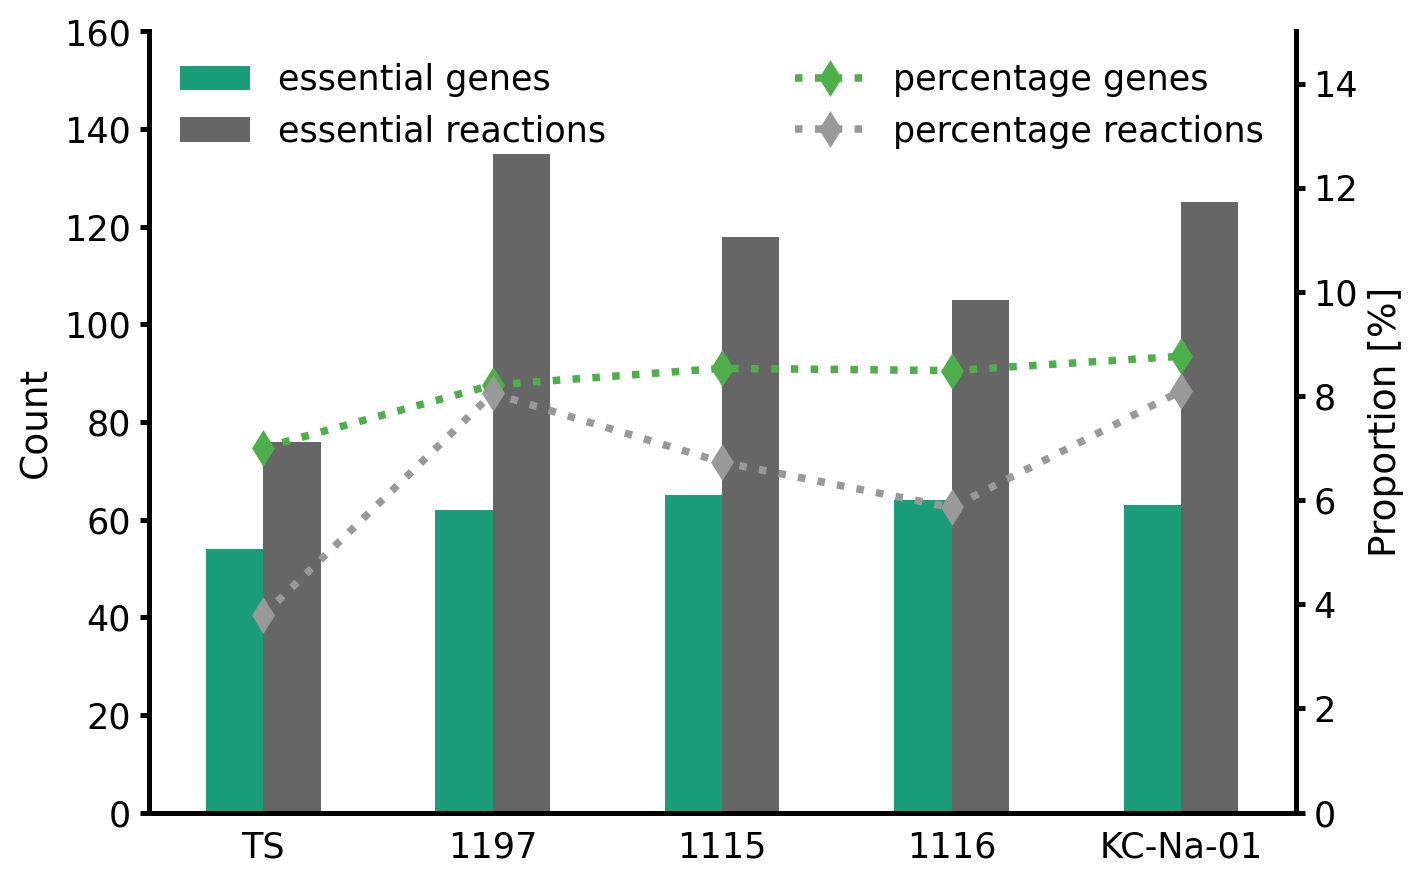

In [282]:
with plt.rc_context({"axes.spines.right" : True}):
    ax = numbers.plot.bar(y=['essential genes', 'essential reactions'], figsize=(8, 5), cmap='Dark2')
    numbers.plot(y=['percentage genes', 'percentage reactions'], ax=ax, use_index=False, linestyle=':', secondary_y=True, marker='d', color=[cb[2], cb[6]], linewidth=3, markersize=9)
    ax.right_ax.set_ylabel('Proportion [%]', fontsize=15)
    ax.right_ax.legend()
    ax.legend(title=False, loc='upper left')
    ax.right_ax.set_ylim([0, 15])
    ax.set_ylim([0,160])
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.set_ylabel('Count', fontsize=15)
    plt.tight_layout()
    plt.savefig('../../analysis/essentiality/essentiality_visualization.png')